In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, SimpleRNN
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
from keras.models import load_model

from pmdarima import auto_arima




# Load Data

In [2]:
df = pd.read_csv('data/data_be.csv')
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
df.drop(['date','ForecastLoad'], axis=1, inplace=True)

df

,price,ActualLoad,weekday,season,period
date,,,,,
2020-01-01 00:00:00,38.60,8700.50,Wednesday,winter,night
2020-01-01 01:00:00,36.55,8320.25,Wednesday,winter,night
2020-01-01 02:00:00,32.32,8000.75,Wednesday,winter,night
2020-01-01 03:00:00,30.85,7795.50,Wednesday,winter,night
2020-01-01 04:00:00,30.14,7784.00,Wednesday,winter,night
...,...,...,...,...,...
2022-12-31 19:00:00,-32.27,8171.75,Saturday,winter,evening
2022-12-31 20:00:00,6.20,7846.25,Saturday,winter,evening
2022-12-31 21:00:00,35.96,7794.00,Saturday,winter,evening


# Data Preprocessing

In [3]:
# One-hot encoding
data = pd.get_dummies(df, columns = ['weekday', 'season','period'])

In [4]:
# creating window sliding data set for multi step time series prediction
def create_dataset(data, target, m, p):
    X, Y = [], []
    for i in range(len(data)-m-p+1):
        #X.append(data[i:i+m])
        X.append(data.iloc[i:i+m,target])
        Y.append(data.iloc[i+m:i+m+p,target])
    return np.array(X), np.array(Y)

In [6]:
# scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data[['price','ActualLoad']])
scaler_y = MinMaxScaler()
scaler_y.fit(data['price'].values.reshape(-1,1))
data_scaled = data.copy()
data_scaled[['price','ActualLoad']] = scaler.transform(data[['price','ActualLoad']])

# Create input-output pairs for the LSTM model
m = 1440 # Number of past observations to use
p = 24  # Number of future observations to predict
indices = data_scaled[m:len(data_scaled)-p+1].index
#X, y = create_dataset(data_scaled,0,m,p)
X, y = create_dataset(data,0,m,p)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, idx_train, idx_test= train_test_split(X,y, indices, test_size=0.005,random_state=42)


In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(idx_train.shape)
print(idx_test.shape)

(24716, 1440)
(125, 1440)
(24716, 24)
(125, 24)
(24716,)
(125,)


# Train ARIMA and SARIMA

In [9]:
def train_sarima(train,test,season,m,p):
    stepwise_model = auto_arima(train, start_p=2, start_q=2,
                           max_p=5, max_q=5, m=m,
                           seasonal=season,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    
    stepwise_model.fit(train)
    pred = stepwise_model.predict(n_periods=p)

    mae = np.mean(np.abs(pred-test))
    mse = mean_squared_error(pred, test)

    return mae, mse


In [10]:
sum_mae = []
sum_mse = []
for i in range(len(X_test)):
    if i % 10 == 0:
        print(i)
    mae, mse = train_sarima(X_test[i],y_test[i],True,m=24,p=p)
    sum_mae.append(mae)
    sum_mse.append(mse)

print(np.mean(sum_mae))
print(np.sqrt(np.mean(sum_mse)))

0
10


# Train simple RNNs

In [8]:
model = Sequential()
model.add(SimpleRNN(p, input_shape=(m, X_train.shape[2])))
model.add(Dense(p,activation='relu'))
model.add(Dense(p,activation='relu'))
model.add(Dense(p))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss', patience=3)

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64,callbacks=[early_stopping])


Epoch 1/5
311/311 [==============================] - 59s 187ms/step - loss: 0.0166
Epoch 2/5
311/311 [==============================] - 66s 211ms/step - loss: 0.0024
Epoch 3/5
311/311 [==============================] - 45s 144ms/step - loss: 0.0021
Epoch 4/5
311/311 [==============================] - 45s 145ms/step - loss: 0.0020
Epoch 5/5
311/311 [==============================] - 54s 173ms/step - loss: 0.0019


## Train LSTM

In [8]:
# Define the model architecture
model = Sequential()
model.add(LSTM(p, input_shape=(m, X_train.shape[2])))
model.add(Dense(p,activation='relu'))
#model.add(Dense(p,activation='relu'))

model.add(Dense(p))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss', patience=3)

# Train the model
model.fit(X_train, y_train, epochs=3, batch_size=64,callbacks=[early_stopping])



Epoch 1/3
300/300 [==============================] - 8125s 27s/step - loss: 0.0059
Epoch 2/3
300/300 [==============================] - 72940s 244s/step - loss: 0.0025
Epoch 3/3
300/300 [==============================] - 12473s 42s/step - loss: 0.0024


## Predict and evaluation

In [9]:
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)


156/156 [==============================] - 5s 33ms/step


13.34034484863281


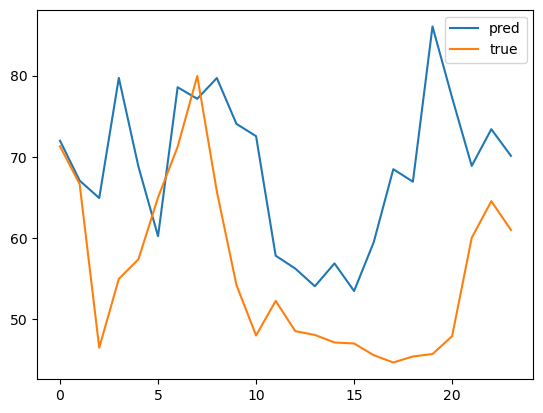

In [11]:
n = 200
print(np.mean(np.abs(y_test[n] - y_pred[n])))
plt.plot(y_pred[n],label='pred')
plt.plot(y_test[n],label = 'true')
plt.legend()
plt.show()

20.246915082861527
24.376275531193187
1.661541058025674


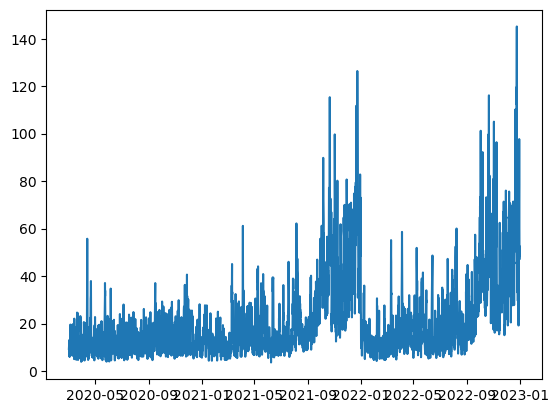

In [12]:
# Model Evaluation
mae = []
rmse = []
mase = []
naives = []
#test_index = test_data.index[1440:len(test_data)-24+1]
for i in range(y_test.shape[0]):
    mae.append(np.mean(np.abs(y_test[i] - y_pred[i])))
    rmse.append(np.sqrt(mean_squared_error(y_test[i],y_pred[i])))
    pred_naive = scaler_y.inverse_transform(X_test[i][:,0].reshape(-1,1)).flatten()[-p:]
    naive = np.mean(np.abs(y_test[i]-pred_naive))
    mase.append(np.mean(np.abs(y_test[i] - y_pred[i]))/naive )
    naives.append(naive)
    
print(np.mean(mae))
print(np.mean(rmse))
print(np.mean(mase))
test_mae = pd.DataFrame({'time':idx_test,'mae':mae})
test_mae.index = test_mae['time']
test_mae.drop(['time'],inplace=True,axis=1)
test_mae.sort_index(inplace=True)
plt.plot(test_mae)